# Pairing Model via VQE

## Setup

In [2]:
# Imports
import qiskit
from qiskit import IBMQ
import math
import cmath
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy import linalg as la
from scipy import linalg as sla
from IPython.display import clear_output
import time
import pickle
from qiskit.extensions import XGate, UnitaryGate
from qiskit import *
from qiskit.compiler import transpile
import networkx as nx
import importlib
from qiskit.quantum_info.synthesis import two_qubit_cnot_decompose as two_qubit_decomp

## Definitions
pi = np.pi

I = np.matrix([[1,0],[0,1]],dtype=complex)
X = np.matrix([[0,1],[1,0]],dtype=complex)
Y = np.matrix([[0,-1j],[1j,0]],dtype=complex)
Z = np.matrix([[1,0],[0,-1]],dtype=complex) 

In [5]:
\newcommand{\acomm}[2]{\{#1,#2\}}$
\newcommand{\comm}[2]{[#1,#2]}$
\newcommand{\ket}[1]{|#1\rangle}$

SyntaxError: unexpected character after line continuation character (1974573391.py, line 1)

## Coupled Cluster Theory

Coupled cluster theory (CC) was first developed to study nuclear physics by Coester and K\"{u}mmel in the 1950's. The ansatz for the theory is given by

\begin{align}
\label{cc_ansatz}
|\Psi\rangle=e^T|\Phi_0\rangle
\end{align}

where $|\Phi_0\rangle$ is the reference state and $T$, the cluster operator, is defined as

\begin{align}
\label{cluster_op_def}
T = \sum_{p=n}^AT_n
\end{align}

where $A$ is the maximum number of particle-hole excitations and each term in the sum is given by

\begin{align}
T_n=\left(\frac{1}{n!}\right)\sum_{\substack{i_1\ldots i_n \\ a_1\ldots a_n}}t_{i_1\ldots i_n}^{a_1\ldots l_n}a^\dagger_{a_1}\ldots a^\dagger_{a_n}a_{i_n}\ldots a_{i_1}
\end{align}

From the time-independent Schrodinger equation $H|\Psi\rangle=E|\Psi\rangle$, one can obtain the coupled cluster energy and amplitude equations

\begin{align}
\label{cc_energy} 
E&=\langle\Phi_0|\overline{H}|\Phi_0\rangle
\\
\label{cc_eq}
0&=\langle\Phi^{a_1\ldots a_n}_{i_1\ldots i_n}|\overline{H}|\Phi_0\rangle
\end{align}

respectively. Here $\bar{H}$ is the similarity transformed (and reference energy shifted) Hamiltonian

\begin{align}
\overline{H}
\equiv
e^{-T}He^T-
\langle\Phi|H|\Phi\rangle
\end{align}

Note that the energy depends on the cluster amplitudes $t_{i_1\ldots i_n}^{a_1\ldots l_n}$, which can be obtained deterministically by solving the amplitude equations. In order to do so, one often expands the similarity transformed Hamiltonian $\overline{H}$ using the Baker-Campbell-Hausdorff (BCH) identity

\begin{align}
e^{-T}He^T
&=
\sum_{n=0}^\infty\frac{1}{n!}\text{ad}^n_TH
\nonumber
\\
&=
\label{cc_bch_expansion}
H+[H,T]+\frac{1}{2}[[H,T],T]+\cdots
\end{align}

where $\text{ad}_ab\equiv[b,a]$. When one plugs this expansion into energy expression it can be shown that, when the when the reference state $\ket{\Phi_0}$ is a single determinant, the expansion terminates at fourth order ($n=4$). Coupled cluster with single determinant reference states usually performs well at equilibrium configurations but poorly for strongly correlated systems. This shortcoming can be overcome with unitary coupled cluster theory.

### Pair Coupled Cluster Doubles (pCCD)

The cluster operator is often be truncated, thus simplifying the computational complexity, while still leading to an expressive ansatz. One such truncation is coupled cluster doubles (CCD) which can further be restricted, for pairing models, to pair coupled cluster doubles (pCCD). In this truncation, the cluster operator is set to a variant of $T_2$ called $T_p$ which is restricted to moving pairs of fermions. That is, $T=T_p$, where

\begin{align}
T_p\equiv\sum_{ia}t^a_iA^\dagger_aA_i
\end{align}

Here, $A^\dagger$ and $A$ are the pair fermionic creation and annihilation operators, respectively, defined as

\begin{align}
\label{pair_op_def}
A^{\dagger}_p &= a^{\dagger}_{p+}a^{\dagger}_{p-}
\\
A_p &= a_{p-}a_{p+}
\end{align}

where $p+$ and $p-$ index the spin-up and spin-down fermions in the $p^{\text{th}}$ energy level, respectively. The coupled cluster equations become

\begin{align}
\label{pccd_energy}
E&=\langle\Phi_0|\overline{H}|\Phi_0\rangle
\\
\label{pccd_eq}
0&=\langle\Phi_i^a|\overline{H}|\Phi_0\rangle
\end{align}

where the similarity transformed Hamiltonian $\overline{H}$ is

\begin{align}
\overline{H}=e^{-T_p}He^{T_p}
\end{align}

and the excited state $\langle\Phi_i^a|$ is obtained by

\begin{align}
\langle\Phi_i^a|=\langle\Phi_0|A^\dagger_iA_a
\end{align}

Note that we truncated the amplitude equation to a single excited state for the pair coupled cluster doubles amplitude equations.

### Unitary Coupled Cluster Theory (UCC)

In unitary coupled cluster (UCC), the cluster operator $T$ is replaced with the purely imaginary operator $T-T^\dagger$, leading to the unitary exponential ansatz

\begin{align}
|\Psi\rangle=e^{T-T^\dagger}|\Phi_0\rangle
\end{align}

This ansatz is variational and thus the ground state energy $E_0$ can be obtained from the variational principle

\begin{align}
E_0=\underset{t}{\min}\langle\Phi_0|\overline{H}|\Phi_0\rangle
\end{align}

where $t$ are the cluster amplitudes, of which $T$ is a function, and $\overline{H}$ is the similarity transformed (and reference energy shifted) Hamiltonian

\begin{align}
\overline{H}\equiv e^{T^\dagger-T}He^{T-T^{\dagger}}-
\langle\Phi_0|H|\Phi_0\rangle
\end{align}

While unitary coupled cluster theory overcomes the weakness of coupled cluster theory, it is not classically tractable to implement. One can see this by expanding the similarity transformed Hamiltonian for UCC using the BCH identity
\begin{align}
e^{T^\dagger-T}He^{T-T^\dagger}
=&
\sum_{n=0}^\infty\frac{1}{n!}\text{ad}^n_{T-T^\dagger}H
\nonumber
\\
=&
\label{ucc_bch_expansion}
\ H+[H,T]-[H,T^\dagger]
\nonumber
\\
+& \ \frac{1}{2}([[H,T],T]+[[H,T^\dagger],T^\dagger])
\nonumber
\\
-& \ [[H,T],T^\dagger] - [[H,T^\dagger],T]+\cdots
\end{align}

which, unlike the expansion for CC, does not naturally truncate and thus it is classically intractable to solve the amplitude and energy equations. Fortunately, unitary operators are implementable on quantum computers (as all gates must be unitary). Thus, UCC is a viable candidate ansatz for the so-called Variational Quantum Eigensolver (VQE) which is discussed in the Quantum Computing chapter.

## Jordan-Wigner Transformation

The Jordan-Wigner transformation was originally developed by Pascual Jordan and Eugene Wigner for one-dimensional lattice models. The transformation is a mapping between fermionic and Pauli operators which stores information locally in the occupation number basis. It is given below as

\begin{align}
a^\dagger_p&=\left(\prod_{n=1}^{p-1}Z_n\right)Q^-_p
\\
a_p&=\left(\prod_{n=1}^{p-1}Z_n\right)Q^+_p
\end{align}

where

\begin{align}
Q^{\pm}_p=
\frac{X_p \pm i Y_p}{2}
\end{align}

and

\begin{align}
P_p = \left(\bigotimes_{n=1}^{p-1}I\right)\otimes P \otimes \left(\bigotimes_{n=p+1}^{N}I\right)
\end{align}

where $P=I,X,Y,Z$ is a Pauli operator and $N$ is the size of the system (number of qubits). To gain some intuition for the mapping, note that action on many-fermionic states is preserved

\begin{align}
a^\dagger_i|n_1\ldots n_n\rangle=
\left(\prod_{n=1}^{p-1}Z_n\right)Q^-_p|n_1\ldots n_n\rangle=
(-1)^{N_p}(1-n_p)|n_1\ldots n_{p-1}1n_{p+1}\ldots n_n\rangle
\end{align}
\begin{align}
a_i|n_1\ldots n_n\rangle=
\left(\prod_{n=1}^{p-1}Z_n\right)Q^+_p|n_1\ldots n_n\rangle=
(-1)^{N_p}n_p|n_1\ldots n_{p-1}0n_{p+1}\ldots n_n\rangle
\end{align}

where $N_p\equiv\sum_{m=1}^{p-1}n_m$, since

\begin{align}
Z|n\rangle&=(-1)^n|n\rangle
\\
Q^-|n\rangle&=(1-n)|1\rangle
\\
Q^+|n\rangle&=n|0\rangle
\end{align}

where $n=0,1$. The mapping holds because it obeys the fermionic anti-commutation relations as verified below: First, consider the case $p=q$. In this case, the anti-commutation relations are

\begin{align}
\{a_p,a^\dagger_p\}
&=
\acomm{\left(\prod_{n=1}^{p-1}Z_n\right)Q^+_p}{\left(\prod_{n=1}^{p-1}Z_n\right)Q^-_p}=
\left(\prod_{n=1}^{p-1}\acomm{Z_n}{Z_n}\right)
\acomm{Q^+_p}{Q^-_p}=
I_p
\end{align}
\begin{align}
\acomm{a_p}{a_p}
&=
\acomm{\left(\prod_{n=1}^{p-1}Z_n\right)Q^+_p}{\left(\prod_{n=1}^{p-1}Z_n\right)Q^+_p}=
\left(\prod_{n=1}^{p-1}\acomm{Z_n}{Z_n}\right)
\acomm{Q^+_p}{Q^+_p}=
0
\end{align}
\begin{align}
\acomm{a^\dagger_p}{a^\dagger_p}=
\acomm{\left(\prod_{n=1}^{p-1}Z_n\right)Q^-_p}{\left(\prod_{n=1}^{p-1}Z_n\right)Q^-_p}=
\left(\prod_{n=1}^{p-1}\acomm{Z_n}{Z_n}\right)
\acomm{Q^-_p}{Q^-_p}=
0
\end{align}
which follow from the fact that
\begin{align}
\acomm{Q^{\pm}_p}{Q^{\mp}_p}
&=
\frac{1}{4}\acomm{X_p \pm iY_p}{X_p \mp iY_p}
\nonumber
\\
&=
\frac{1}{4}(\acomm{X_p}{X_p} \mp i\acomm{X_p}{Y_p} \pm i\acomm{Y_p}{X_p}+\acomm{Y_p}{Y_p})
=I_p
\end{align}
while
\begin{align}
\acomm{Q^{\pm}_p}{Q^{\pm}_p}
&=
\frac{1}{4}\acomm{X_p \pm iY_p}{X_p \pm iY_p}
\nonumber
\\
&=
\frac{1}{4}(\acomm{X_p}{X_p} \pm i\acomm{X_p}{Y_p} \pm i\acomm{Y_p}{X_p}-\acomm{Y_p}{Y_p})
=0
\end{align}

Second, consider the case $p\neq q$. Without loss of generality, we can set $p<q$. In this case, the anti-commutation relations are

\begin{align}
\acomm{a_p}{a^\dagger_q}
&=
\acomm{\left(\prod_{n=1}^{p-1}Z_n\right)Q^+_p}{\left(\prod_{n=1}^{q-1}Z_n\right)Q^-_p}
\\
&=
\left(\prod_{n=1}^{p-1}\acomm{Z_n}{Z_n}\right)
\acomm{Q^+_p}{Z^-_p}
\left(\prod_{m=p+1}^{q-1}\acomm{I_n}{Z_m}\right)
\acomm{I_q}{Q^-_q}=
0
\end{align}
\begin{align}
\acomm{a_p}{a_q}
&=
\acomm{\left(\prod_{n=1}^{p-1}Z_n\right)Q^+_p}{\left(\prod_{n=1}^{q-1}Z_n\right)Q^+_p}
\\
&=
\left(\prod_{n=1}^{p-1}\acomm{Z_n}{Z_n}\right)
\acomm{Q^+_p}{Z^-_p}
\left(\prod_{m=p+1}^{q-1}\acomm{I_n}{Z_m}\right)
\acomm{I_q}{Q^+_q}=
0
\end{align}
\begin{align}
\acomm{a^\dagger_p}{a^\dagger_q}
&=
\acomm{\left(\prod_{n=1}^{p-1}Z_n\right)Q^-_p}{\left(\prod_{n=1}^{q-1}Z_n\right)Q^-_p}
\\
&=
\left(\prod_{n=1}^{p-1}\acomm{Z_n}{Z_n}\right)
\acomm{Q^-_p}{Z^-_p}
\left(\prod_{m=p+1}^{q-1}\acomm{I_n}{Z_m}\right)
\acomm{I_q}{Q^-_q}=
0
\end{align}

which follow from the fact that

\begin{align*}
\acomm{Q^{\pm}_p}{Z_p}=\frac{1}{2}\acomm{X \mp iY}{Z}
=\frac{1}{2}\left(\acomm{X}{Z}\mp i\acomm{Y}{Z}\right)=0
\end{align*}

### Pair Jordan-Wigner Transformation

The Jordan-Wigner transformation is simplified when dealing with pair fermionic operators:

\begin{align}
A^\dagger_p&=Q^-_p
\\
A_p&=Q^+_p
\\
N_p&=1-Z_p
\end{align}

where

\begin{align}
\label{pair_fermionic_operators}
N_p &= \sum_{\sigma}a^\dagger_{p\sigma}a_{p\sigma}
\\
A^{\dagger}_p &= a^{\dagger}_{p+}a^{\dagger}_{p-}
\\
A_p &= a_{p-}a_{p+}
\end{align}

Namely, the string of $Z$ operators preceding the $Q^\pm$ operator is dropped. This is one of the main advantages of working with the nuclear pairing model. Because it can be written in terms of pair fermionic operators, it's mapping to quantum operators is greatly simplified. This mapping holds because it obeys the pair fermionic commutation relations as verified below:

\begin{align}
\comm{A_p}{A^\dagger_q}
&=
\comm{Q^+_p}{Q^-_q}
\nonumber
\\
&=
\frac{1}{4}\comm{X_p+iY_p}{X_q-iY_q}
\nonumber
\\
&=
\frac{1}{4}(\comm{X_p}{X_q}-i\comm{X_p}{Y_q}+i\comm{Y_p}{X_q}+\comm{Y_p}{Y_q})
\nonumber
\\
&=
\delta_{pq}Z_p
\nonumber
\\
&=
\delta_{pq}(1-N_p)
\end{align}
\begin{align}
\comm{N_p}{A^\dagger_q}
&=
\comm{I_p-Z_p}{Q^-_q}
\nonumber
\\
&=
\frac{1}{2}\comm{I_p-Z_p}{X_q-iY_q}
\nonumber
\\
&=
\frac{1}{2}(\comm{I_p}{X_q}-i\comm{I_p}{Y_q}-\comm{Z_p}{X_q}+i\comm{Z_p}{Y_q})
\nonumber
\\
&=
\delta_{pq}\left(\frac{X_p-iY_p}{2}\right)
\nonumber
\\
&=
\delta_{pq}A^\dagger_p
\end{align}
\begin{align}
\comm{N_p}{A_q}
&=
\comm{I_p-Z_p}{Q^+_q}
\nonumber
\\
&=
\frac{1}{2}\comm{I_p-Z_p}{X_q+iY_q}
\nonumber
\\
&=
\frac{1}{2}(\comm{I_p}{X_q}+i\comm{I_p}{Y_q}-\comm{Z_p}{X_q}-i\comm{Z_p}{Y_q})
\nonumber
\\
&=
\delta_{pq}\left(\frac{X_p+iY_p}{2}\right)
\nonumber
\\
&=
\delta_{pq}A_p
\end{align}

## Pairing Model

The pairing model consists of $2N$ fermions that occupy $N$ of $P$ energy levels. The fermions can only change energy level by pair. It's Hamiltonian is

\begin{align}
H=\sum_{p\sigma} d_pa_{p\sigma}^{\dagger}a_{p\sigma}+\sum_{pq}g^p_qa_{p+}^{\dagger}a_{p-}^{\dagger}a_{q-}a_{q+}
\end{align}

where $p$ and $q$ sum over the set  $\{1,...,P\}$ and $\sigma$ sums over the set $\{+,-\}$. Also, $a$ and $a^{\dagger}$ are the fermionic creation and annihilation operators. A schematic of the pairing model is given in Figure 1 below:

<img src="pairing_pic.jpg" width=400 height=400 />

One can rewrite the pairing model as

\begin{align}
\label{pairing_model_hamiltonian}
H_p=\sum_pd_pN_p+\sum_{pq}g^p_qA^\dagger_pA_q
\end{align}

which is written in terms of the pair number operator $N_p$ and the pair fermionic creation and annihilation operators $A^\dagger_p$ and $A_p$ which are defined as follows

\begin{align}
N_p &= \sum_{\sigma}a^\dagger_{p\sigma}a_{p\sigma}
\\
A^{\dagger}_p &= a^{\dagger}_{p+}a^{\dagger}_{p-}
\\
A_p &= a_{p-}a_{p+}
\end{align}

where $\sigma\in\{+,-\}$. These operators satisfy the $\text{SU}(2)$ algebra described by the following commutation relations

\begin{align}
\label{AAd_comm}
[A_p,A^\dagger_q]&=\delta_{pq}(1-N_p)
\\
[N_p,A^\dagger_q]&=2\delta_{pq}A^\dagger_p
\\
\label{NA_comm}
[N_p,A_q]&=-2\delta_{pq}A_p
\end{align}

For this example, we choose the single-particle energies $d_p$ to increase linearly with $p$ and the pairing strength $g_{pq}$ to be a constant $(g)$. That is

\begin{align}
d_p&=p 
\nonumber
\\ 
g_{pq}&=g
\label{dg_cond}
\end{align}

### Exact Solution

Richardson discovered an exact solution to the pairing model (with constant $g$):

\begin{align}
1
+
\sum_{\kappa=1}^P
\frac{g}{2d_\kappa-E_\alpha}
+
\sum_{\beta=1,\beta\neq\alpha}^N
\frac{2g}{E_\alpha-E_\beta}=
0
\end{align}

where we've relabeled $\gamma\to\beta$. This is a set of coupled, non-linear equations from which one solves for the terms $E_\alpha$ and sums them to find the energy; recall

\begin{align}
E=\sum_{\alpha=1}^N E_\alpha
\end{align}

However, the Richardson equations are notoriously difficult to solve, due to the presence of singularities.

### Unitary Pair Coupled Cluster Doubles Ansatz

The unitary coupled cluster ansatz is

\begin{align}
|\Psi\rangle=e^{T-T^{\dagger}}|\Phi\rangle
\end{align}

where $|\Phi\rangle$ is a Fock state and $T=\sum_{k=1}^AT_k$. Since our Hamiltonian only has one body terms. We will truncate to $T=T_1$ where 

\begin{align}
T_1=\sum_{ia}t_i^aA_a^{\dagger}A_i
\end{align}

Thus, we define our ansatz as

\begin{align}
|\Psi(\theta)\rangle
&=
e^{T_1-T_1^{\dagger}}\ket{\Phi}
\\
&=
\exp\left\{\sum_{ia}\theta_i^a\left(A_a^{\dagger}A_i-A_aA_i^{\dagger}\right)\right\}\ket{\Phi}
\end{align}
We define the set of angles $\theta=\{t_i^a \ | \ i < F, \ a \geq F\}$ where $F$ is the number of particles below the Fermi level.

### Mapping the Ansatz

___

##### Problem 1: Mapping Pair Operators to Pauli Gates

Use the pair Jordan-Wigner transformation from pair operators to Pauli matrices

\begin{align}
A_p &= \frac{X_p+iY_p}{2} \\
A_p^{\dagger} &= \frac{X_p-iY_p}{2}
\end{align}

to prove

\begin{align}
A_a^{\dagger}A_i-A_aA_i^{\dagger}
=\frac{i}{2}\left(X_aY_i-Y_aX_i\right)
\end{align}

___

So the Ansatz becomes

\begin{align}
\ket{\Psi(\theta)}
=\exp\left\{\frac{i}{2}\sum_{ia}t_i^a\left(X_aY_i-Y_aX_i\right)\right\}\ket{\Phi}
\end{align}

which to first order Trotter approximation is

\begin{align}
\ket{\Psi(\theta)}=
\prod_{ia}A^i_a\ket{\Phi}
\end{align}
where 
\begin{align}
A^i_a=
\exp\left\{\frac{i}{2}t_i^a\left(X_aY_i-Y_aX_i\right)\right\}\ket{\Phi}
\end{align}

### Mapping the Hamiltonian

First, we'll separate the pairing Hamiltonian 

\begin{align}
\label{pairing_model_hamiltonian2}
H=\sum_{p=1}^PpN_p+g\sum_{p,q=1}^PA^\dagger_p A_q
\end{align}

into strict one-body and two-body terms, as follows

\begin{align}
\label{pairing_model_hamiltonian_strict}
H=
\frac{1}{2}\sum_{p=1}^P(2p+g)N_p
+g\sum_{\substack{p,q=1 \\ p\neq q}}^PA^\dagger_pA_q
\end{align}

___

##### Problem 2:

Prove that the two writings of the Hamiltonian above are indeed equivalent.

___


To deal with the second term, we note that the sum can be broken up as

\begin{align}
\sum_{\substack{p,q=1 \\ p\neq q}}^PA^\dagger_pA_q
&=
\sum_{\substack{p,q=1 \\ p<q}}^PA^\dagger_pA_q
+
\sum_{\substack{p,q=1 \\ q<p}}^PA^\dagger_pA_q
\\
\label{aa_sum2}
&=
\sum_{\substack{p,q=1 \\ p<q}}^PA^\dagger_pA_q
+
\sum_{\substack{p,q=1 \\ p<q}}^PA^\dagger_qA_p
\\
\label{aa_sum3}
&=
\sum_{\substack{p,q=1 \\ p<q}}^P(A^\dagger_pA_q+A_pA^\dagger_q)
\end{align}

where we've swapped the indices $p\leftrightarrow q$ and used the fact that $\comm{A_p}{A^\dagger_q}=0$ for $p\neq q$ (which $p<q$ implies) to obtain. 

___

##### Problem 3:

Apply the Jordan-Wigner transformation to prove

\begin{align}
A^\dagger_pA_q+A_pA^\dagger_q=
\frac{X_pX_q+Y_pY_q}{2}
\end{align}

___

All together, the pairing Hamiltonian after Jordan-Wigner transformation, becomes

\begin{align}
H
&=
\frac{1}{2}\sum_{p=1}^P(2p+g)(I_p-Z_p)
\nonumber
\\
&+
\frac{g}{2}\sum_{\substack{p,q=1 \\ p<q}}(X_pX_q+Y_pY_q)
\end{align}

$\newcommand{\acomm}[2]{\{#1,#2\}}$
$\newcommand{\comm}[2]{[#1,#2]}$
$\newcommand{\ket}[1]{|#1\rangle}$

### Visualizing the Hamiltonian Matrix

Next we'll define some functions in order to create the Hamiltonian Matrix

In [15]:
# Create Pauli signma with index p with length P
def pauli(sigma,p,P):

    # initialize
    if p == 0:
        op = sigma
    else:
        op = I
    
    # Create the operator
    for i in range(1,P):
        if i == p:
            op = np.kron(op,sigma)
        else:
            op = np.kron(op,I)
      
    # Return
    return op

# create the pairing model hamiltonian
def pairing_hamiltonian(P,g):
    
    # initialize H
    H = np.zeros((2**P,2**P),dtype=complex)
   
    for p in range(P):
        H += (1/2)*(2*p+g)*(pauli(I,p,P)-pauli(Z,p,P))
        
    for p in range(P):
        for q in range(p+1,P):
            H += (g/2)*(pauli(X,p,P) @ pauli(X,q,P) + pauli(Y,p,P) @ pauli(Y,q,P))
        
    return H

# function to conver 0 and 1 to the vectors |0> and |1>
def basis(x):

    if x == 0:
        return np.array([[1],[0]],dtype=complex)

    elif x == 1:
        return np.array([[0],[1]],dtype=complex)

    else: print("x must be 0 or 1")

# convert bitstrings to vectors
def bs_to_vectors(states):

    vectors = []
    for i in range(len(states)):
        vector = basis(states[i][0])
        
        for j in range(1,len(states[i])):
            vector = np.kron(vector,basis(states[i][j]))
            
        vectors.append(vector)
        
    return vectors

# function to create list of all 
# possible bitstrings with Hamming weight N
def states(p,n,state,state_list):
    
    if (p < n):
        print("p must be greater than n")
    
    elif (p == n):
        for i in range(p):
            state += [1]
        state_list.append(state)
        return state_list
    
    elif (n == 0):
        for i in range(p):
            state += [0]
        state_list.append(state)
        return state_list
     
    else:
        state_0 = state + [0]
        state_1 = state + [1]
        
        return states(p-1,n-1,state_1,state_list) and states(p-1,n,state_0,state_list)

# get the block of the pairing model hamiltonian
# corresponding to N pairs of fermions
def pairing_hamiltonian_block(P,N,g):
    
    # get the pairing model hamiltonian
    H = pairing_hamiltonian(P,g)
    
    # create list vectors of all possible 
    # bitstrings with Hamming weight N
    vectors = bs_to_vectors(states(P,N,[],[]))
    
    H_mat = np.zeros((len(vectors),len(vectors)),dtype=complex)
    
    for i in range(len(vectors)):
        for j in range(i,len(vectors)):
            H_mat[i][j] = (np.conj(vectors[i].T) @ H @ vectors[j])[0][0]
            H_mat[j][i] = H_mat[i][j]
      
    return np.real(H_mat)

### Create Pairing Model Hamiltonian Matrix

In [16]:
# parameters
P = 4
N = 2
g = -1

# see possible states
print("States =")
print(states(P,N,[],[]))
print("Hamiltonian =")
print(pairing_hamiltonian_block(P,N,g))

States =
[[1, 1, 0, 0], [1, 0, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1]]
Hamiltonian =
[[ 0. -1. -1. -1. -1.  0.]
 [-1.  2. -1. -1.  0. -1.]
 [-1. -1.  4.  0. -1. -1.]
 [-1. -1.  0.  4. -1. -1.]
 [-1.  0. -1. -1.  6. -1.]
 [ 0. -1. -1. -1. -1.  8.]]


___

##### Problem 4:

Why does the Hamiltonian matrix above have the form that it does? How would it change if you changed to $g=-2$. Make a prediction and then check it!

___

### Full-Configuration Interaction (FCI) Solution

Before we jump into VQE, let's first make a plot of the exact ground state correlation energy for various g by diagonalizing the Hamiltonian matrix block. Note that this can be done because we are considering a small system.

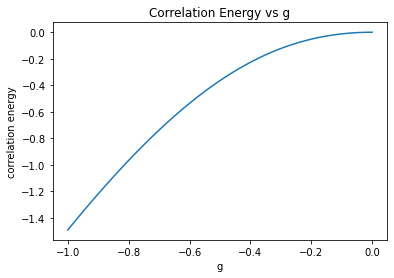

In [17]:
# parameters
P = 4
N = 2
g_min = -1
g_max = 0
g_num = 100
g_list = np.linspace(g_min,g_max,g_num)

# initialize correlation energy list
e_list = []

# loop through g_list
for g in g_list:
    
    # get hamiltonian
    H = pairing_hamiltonian_block(P,N,g)
    
    # get ground state correlation energy
    e_vec, e_val = la.eig(H)
    e_min = np.real(min(e_vec))
    e_ref = H[0][0]
    e_corr_min = e_min-e_ref
    e_list.append(e_corr_min)
    
# plot
plt.plot(g_list,e_list)
plt.title('Correlation Energy vs g')
plt.xlabel('g')
plt.ylabel('correlation energy')
plt.show()

## VQE

### Implementing the Ansatz

The first step we'll take to execute VQE is to implement the ansatz as a quantum circuit. Recall that our ansatz is:

\begin{align}
\ket{\Psi(t)}=
\prod_{ia}A^i_a\ket{\Phi}
\end{align}
where 
\begin{align}
A^i_a=
\exp\left\{\frac{i}{2}t_i^a\left(X_aY_i-Y_aX_i\right)\right\}\ket{\Phi}
\end{align}

First, we have to pick as starting state $\ket{\Phi}$. One can pick any of the states from above but for this instance (you'll see why later) we'll pick

$$
\ket{\Phi}=\ket{1100}
$$

which is created with the following circuit:

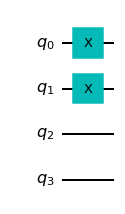

In [18]:
# create four-qubit quantum register
# and four-bit classical register
q = QuantumRegister(4,'q')

# initialize quantum circuit
circ = QuantumCircuit(q)

# prepare |Phi>
circ.x(q[0])
circ.x(q[1])

# draw circuit
circ.draw('mpl')

To go from $\ket{\Phi}$ to $\ket{\Psi(t)}$ we must apply the 4 $A^i_a$ terms that come from $i=0,1$ and $a=2,3$:

$$
\begin{align}
A^0_2&=\exp\left\{\frac{i}{2}t_0^2\left(X_2Y_0-Y_2X_0\right)\right\}
\\
A^0_3&=\exp\left\{\frac{i}{2}t_0^3\left(X_3Y_0-Y_3X_0\right)\right\}
\\
A^1_2&=\exp\left\{\frac{i}{2}t_2^1\left(X_2Y_1-Y_2X_1\right)\right\}
\\
A^1_3&=\exp\left\{\frac{i}{2}t_3^1\left(X_3Y_1-Y_3X_1\right)\right\}
\end{align}
$$

If our quntum computer had all-to-all qubit-connectivity, this would be quite simple. But, we're going to assume that we only have linear connectivity (which is common in most of today's quantum computers). That is, one can only apply two-qubit gates between neighboring qubits

$q_0 - q_1 - q_2 - q_3$

which in our 4 qubit case means between the qubit pairs $(q_0,q_1)$, $(q_1,q_2)$, and $(q_2,q_3)$. How then are we going to apply, for instance, the gate $A^0_3$ when $q_0$ and $q_3$ aren't even connected? To do so, we will use a SWAP network, which is an ansatz technique that utilizes the SWAP gate. The SWAP gate has the following matrix form:

In [19]:
# define swap gate
swap = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

# print swap gate matrix
print('SWAP =')
print(swap)

SWAP =
[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]


The SWAP gate "swaps" the states of the two qubits upon which it acts:

$\text{SWAP}\ket{xy} = \ket{yx}$

___

##### Problem 5

Verify this via matrix-vector multiplication with $\ket{x}=a\ket{0}+b\ket{1}$ and $\ket{y}=c\ket{0}+d\ket{1}$.

___

The SWAP gate is notated as follows:

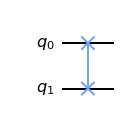

In [20]:
# create two-qubit quantum register
q = QuantumRegister(2,'q')

# initialize quantum circuit
circ = QuantumCircuit(q)

# prepare SWAP
circ.swap(q[0],q[1])

# draw circuit
circ.draw('mpl')

The SWAP gate is decomposed into three alternating CNOTs as follows:

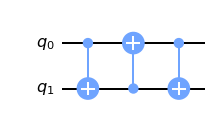

In [21]:
# create two-qubit quantum register
q = QuantumRegister(2,'q')

# initialize quantum circuit
circ = QuantumCircuit(q)

# prepare SWAP
circ.cnot(q[0],q[1])
circ.cnot(q[1],q[0])
circ.cnot(q[0],q[1])

# draw circuit
circ.draw('mpl')

___

##### Problem 6:

Verify this CNOT decomposition of SWAP.

___

Now that we know all about the SWAP gate, let's return to the SWAP network and learn how we can use it to implement our ansatz. To learn about it, take a look at the SWAP network that implements our ansatz below:

<img src="swap_network.jpg" width=400 height=400 />

Here, $SA^i_a = (\text{SWAP})(A^i_a)$. This means that, at each step, $SA^i_a$ applies $A^i_a$ and then swaps the two qubits.

___

##### Problem 7:

Verify that the SWAP network above allows us to implement each of the required $A^i_a$ gates by tracking the order of the qubits after each column of gates is applied. In what order are the qubits at the end? We have need to know this so we can tell the classical computer which qubit is which!
___

___

##### Problem 8 (Challenge):

The SWAP network above has a depth of 3 columns. If one had access to a quantum computer with circular qubit-connectivity (the same as linear but the first and last qubits ($q_0$ and $q_3$) are connected), how could you implement the ansatz with a depth of just 2 columns? Can you code it in Qiskit? What would be the order of the qubits at the end?

___

___

##### Problem 9 (Challenge):

How would you generalize this ansatz for arbitrary number of qubits $P$ and arbitrary number of holes $N$? Hint: the ansatz takes the shape of a parallelagram. 

___

___ 

##### Problem 10

Create the ansatz above in Qiskit. First we have to decompose the gates $SA^i_a$:

In [22]:
# decompose SA^i_a gate, parameterized by t^i_a
def SA(i,a,t):
    
    # initialize circuit
    q = QuantumRegister(2,'q')
    circ = QuantumCircuit(q)
    
    # define SWAP
    swap = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

    # define matrix for SA
    SA = swap @ sp.linalg.expm(1j*(t[i][a]/2)*(np.kron(X,Y)-np.kron(Y,X)))
    
    # decompose using KAK decomposition
    SA = qiskit.quantum_info.synthesis.two_qubit_cnot_decompose(SA)
    
    # return decomposition
    return SA

In [23]:
# create ansatz
def ansatz(t_list):
    
    # create registers
    q = QuantumRegister(4,'q')
    c = ClassicalRegister(4,'c')

    # initialize quantum circuit
    circ = QuantumCircuit(q,c)

    # prepare |Phi>
    circ.x(q[0])
    circ.x(q[1])
    
    # Create t matrix
    t = np.zeros((4,4))
    cnt = 0
    for i in range(2):
        for a in range(2,4):
            t[i][a] = t_list[cnt]
            cnt += 1
    
    # apply SWAP network
    circ.append(SA(1,2,t),[q[1],q[2]])
    
    ### YOUR CODE HERE ###

    # return circuit
    return circ

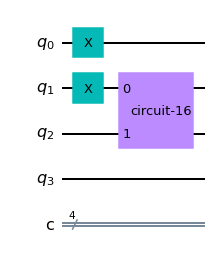

In [24]:
# view ansatz circuit
t_list = [np.random.uniform(0,2*pi) for p in range(4)]
circ = ansatz(t_list)
circ.draw('mpl')

### Expectation Values

Now that we've defined the ansatz, we need to define functions to take the expectation values. Let's start with the first term of the Hamiltonian:

$$
\begin{align}
\frac{1}{2}\sum_{p=1}^P(2p+g)(I_p-Z_p)
\end{align}
$$

It is a sum of $I-Z$ terms, both of which don't require any rotation because $Z$ is the computational basis and $I$ is, well, the identity. However, we can save the classical computer some expectation-value-finding post-processing power by recognizing that

$$ \frac{I-Z}{2} = \frac{1}{2}(|0\rangle\langle0|+|1\rangle\langle1|) - (|0\rangle\langle0|-|1\rangle\langle1|) = |1\rangle\langle1| $$

is simply the number operator. So, for each $p$, we simply add the probabilities of each measurement that has a 1 at the pth index. Thus, the expectation value of each term in the first term of the Hamiltonian can be calculated from the resulting measurments of the unrotated circuit using the following function:

In [25]:
# expectation value of 1-body term
def expect_1(counts,shots,p):
    
    # calculate expectation value
    exp_val = 0
    counts = dict(counts)
    for key in list(counts.keys()):
        # check if pth qubit was measured to be 1
        if [int(x) for x in list(key)][p] == 1:
            exp_val += counts[key]/shots

    # return expectation value
    return exp_val

Now let's turn to the second term of the Hamiltonian:

$$
\begin{align}
\frac{g}{2}\sum_{\substack{p,q=1 \\ p<q}}(X_pX_q+Y_pY_q)
\end{align}
$$

The naive way to take the expectation value of this term would require rotating to each of the 12 different two-body terms 

$$
\begin{align}
& XXII, \ XIXI, \ XIIX, \ IXXI, \ IXIX, \ IIXX, \ YYII, \ YIYI, \ YIIY, \ IYYI, \ IYIY, \ IIYY
\end{align}
$$

which would of course require 12 different circuits! However, note that the first 6 all commute with each other and the last 6 all commute with each other. From quantum mechanics we know that we should be able to measure the first 6 simultaneously and thelast 6 simultaneously. To this end, we only need to rotate to two different basis:

$$ XXXX, \ YYYY $$

Why? Take for example $XXXX$, to whom's basis is rotated via

$$\ket{\psi}\to H\otimes H\otimes H\otimes H \ket{\psi}$$

Now, suppose we wanted to find the expectation value of $IXXI$. We simply take the expectation value of $IZZI$ in this state, since:

$$
\begin{align}
&
\langle H\otimes H\otimes H\otimes H \psi|I\otimes Z\otimes Z\otimes I|H\otimes H\otimes H\otimes H \psi \rangle
\\
= \ &
\langle\psi|HIH\otimes HZH\otimes HZH\otimes HIH|\psi \rangle
\\
= \ &
\langle\psi|I\otimes X\otimes X\otimes I|\psi \rangle
\end{align}
$$

##### Problem 11:

Therefore, we'll create two functions that rotate to each of these two basis:

In [26]:
## circuit to rotate to XXXX basis
def rotate_to_xxxx(circ):
    
    for q in range(4):
        circ.h(circ.qubits[q])
    
    return circ

## circuit to rotate to YYYY basis
def rotate_to_yyyy(circ):
    
    ### YOUR CODE HERE ###
    
    return circ

The expectation value of each term in the second term of the Hamiltonian can thus be calculated from the resulting measurements of the corresponding rotated basis with the following functions:

In [27]:
## calculate (-1)**(restricted hamming weight of bit string)
def sign(key,lst):
    
    bit_str = [int(x) for x in key]
    
    # calculate restricted Hamming weight
    hw = 0
    for i in range(len(bit_str)):
        if lst[i] == 1:
            hw += bit_str[i]
            
    return (-1)**hw

# expectation value of 2-body term
def expect_2(counts,shots,lst):
    
    # calculate expectation value
    exp_val = 0
    counts = dict(counts)
    for key in list(counts.keys()):
        exp_val += sign(key,lst)*counts[key]/shots
    
    # Return expectation value
    return exp_val

We'll now put it all together and write a function that returns the expectation value of the Hamiltonian given the input angles $t$. This is the so-called objective function:

In [28]:
# bit_term
def bit_term(i,j,n):
    
    term = []
    
    for k in range(n):
        if (k == i) or (k == j):
            term.append(1)
        else:
            term.append(0)
            
    return term

# Get counts for IIII, XXXX, and YYYY bases.
def vqe_counts(t_list,pauli):

    # create circuit
    circ = ansatz(t_list)
    
    # rotate
    if pauli == 'I':
        pass
    
    if pauli == 'X':
        circ = rotate_to_xxxx(circ)
        
    if pauli == 'Y':
        circ = rotate_to_yyyy(circ)
        
    # flip out of Qiskit convetion
    circ = circ.reverse_bits()
    
    # measure with new qubit order in mind
    circ.measure(circ.qubits[0],circ.clbits[2])
    circ.measure(circ.qubits[1],circ.clbits[3])
    circ.measure(circ.qubits[2],circ.clbits[0])
    circ.measure(circ.qubits[3],circ.clbits[1])
    
    # get counts
    counts = execute(circ, qiskit.Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts(circ)
        
    return counts

# vqe_expect
def vqe_expect(t_list,constants):
    
    # extract contants
    g = constants[0]
    shots = constants[1]
    
    # get counts from each basis
    counts_i = vqe_counts(t_list,'I')
    counts_x = vqe_counts(t_list,'X')
    counts_y = vqe_counts(t_list,'Y')
    
    # initialize energy
    E = 0
    
    # one-body term
    for p in range(4):
        E += (2*p+g)*expect_1(counts_i,shots,p)

    # two-body term
    for p in range(4):
        for q in range(p+1,4):
            lst = bit_term(p,q,4)
            E += (g/2)*(expect_2(counts_x,shots,lst)+expect_2(counts_y,shots,lst))           

    # Return energy
    return E

Finally we'll define the function that runs the classical minimization algorithm:

In [29]:
# find ground state correlation energy
def vqe(t_list,g,shots,method):

    # Define constants
    constants = [g,shots]

    # get true (exact) ground state correlation energy
    H = pairing_hamiltonian_block(4,2,g)
    e_vec, e_val = la.eig(H)
    e_min = np.real(min(e_vec))
    e_ref = H[0][0]
    e_ext = e_min-e_ref
    
    # callback function for visualization of minimization
    diff = []
    def callback(x):
        diff.append(vqe_expect(x,constants)-e_min)
        itr = np.linspace(1,len(diff),len(diff))
        plt.xlabel('Iterations')
        plt.ylabel('Energy Difference')
        plt.title('Energy Difference vs Iterations')
        plt.plot(itr,diff)
        clear_output(wait=True)
        plt.show()
    
    # minimize
    opt = sp.optimize.minimize(vqe_expect, x0=t_list, args=constants, method=method, callback=callback)
    
    # get t_min
    t_min = opt.x
    
    # get estimated ground state correlation energy
    e_est = vqe_expect(t_min,constants) - e_ref
    
    # Return true and calculated
    return e_est, e_ext, t_min

Let's run VQE for a few different values of g and see how it compares to the exact answer:



In [30]:
def amp_init(g):
    
    # initialize t
    t = np.zeros((4,4))
    
    # define t
    for i in range(2):
        for a in range(2,4):
            t[i][a] = (g/2)/(i-a+g)
    
    # return t
    return t

In [31]:
# parameters
P = 4
N = 2
g_min = -1
g_max = 0
shots = 2**10
method = 'Powell'

# initialize correlation energy lists
e_ext_list = []
e_vqe_list = []

## exact 
g_ext_list = np.linspace(g_min,g_max,100)

# loop through g_list
for g in g_ext_list:
    
    # get ground state correlation energy
    H = pairing_hamiltonian_block(P,N,g)
    e_vec, e_val = la.eig(H)
    e_min = np.real(min(e_vec))
    e_ref = H[0][0]
    e_corr_min = e_min-e_ref
    e_ext_list.append(e_corr_min)
    
## vqe
g_vqe_list = np.linspace(g_min,g_max,5)

# loop through g_vqe_list
for g in g_vqe_list:
    
    print('g =',g)
    
    # get ground state correlation energy
#     t_list = [np.random.uniform(0,2*pi) for p in range(4)]
    t_list = amp_init(g)
    print(t_list)
    e_vqe, e_ext, t_min = vqe(t_list,g,shots,method)
    print('e_vqe =',e_vqe)
    print('e_exact =',e_ext)
    e_vqe_list.append(e_vqe)
    
# plot
plt.plot(g_ext_list,e_ext_list,label='e_exact')
plt.scatter(g_vqe_list,e_vqe_list,label='e_vqe')
plt.title('Correlation Energy vs g')
plt.xlabel('g')
plt.ylabel('correlation energy')
plt.show()

g = -1.0
[[0.         0.         0.16666667 0.125     ]
 [0.         0.         0.25       0.16666667]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


AttributeError: module 'scipy' has no attribute 'optimize'

## Solutions

### Problem 1:

\begin{align}
A_a^{\dagger}A_i-A_aA_i^{\dagger}
&=\left(\frac{X_a-iY_a}{2}\right)\left(\frac{X_i+iY_i}{2}\right) \\
&-\left(\frac{X_a+iY_a}{2}\right)\left(\frac{X_i-iY_i}{2}\right)
\\
&=\frac{i}{2}\left(X_aY_i-Y_aX_i\right)
\end{align}

### Problem 2:

When $p=q$ in the second sum

\begin{align}
A^\dagger_pA_p
&=
\left(\frac{X_p-iY_p}{2}\right)\left(\frac{X_p+iY_p}{2}\right)
\\
&=
\frac{I_p-Z_p}{2}
\\
\label{np/2}
&=
\frac{N_p}{2}
\end{align}

### Problem 3:

\begin{align}
A^\dagger_pA_q+A_pA^\dagger_q
&=
\left(\frac{X_p-iY_p}{2}\right)\left(\frac{X_q+iY_q}{2}\right)
\nonumber
\\
&+
\left(\frac{X_p+iY_p}{2}\right)\left(\frac{X_q-iY_q}{2}\right)
\\
&=
\frac{X_pX_q+Y_pY_q}{2}
\end{align}

### Problem 10:

In [197]:
# create ansatz
def ansatz(t_list):
    
    # create registers
    q = QuantumRegister(4,'q')
    c = ClassicalRegister(4,'c')

    # initialize quantum circuit
    circ = QuantumCircuit(q,c)

    # prepare |Phi>
    circ.x(q[0])
    circ.x(q[1])
    
    # Create t matrix
    t = np.zeros((4,4))
    cnt = 0
    for i in range(2):
        for a in range(2,4):
            t[i][a] = t_list[cnt]
            cnt += 1
    
    # apply SWAP network
    circ.append(SA(1,2,t),[q[1],q[2]])
    circ.append(SA(0,2,t),[q[0],q[1]])
    circ.append(SA(1,3,t),[q[2],q[3]])
    circ.append(SA(0,3,t),[q[1],q[2]])

    # return circuit
    return circ

### Problem 11:

In [198]:
## circuit to rotate to YY basis
def rotate_to_yyyy(circ):
    
    for q in range(4):
        circ.sdg(circ.qubits[q])
        circ.h(circ.qubits[q])
    
    return circ